# Creating Feature Groups
---

The Hopsworks feature store is a centralized repository, within an organization, to manage machine learning features.

A feature is a measurable property of a phenomenon. It could be a simple value such as the age of a customer, or it could be an aggregated value, such as the number of transactions made by a customer in the last 30 days.

A feature is not restricted to a numeric value, it could be a string representing an address, or an image.

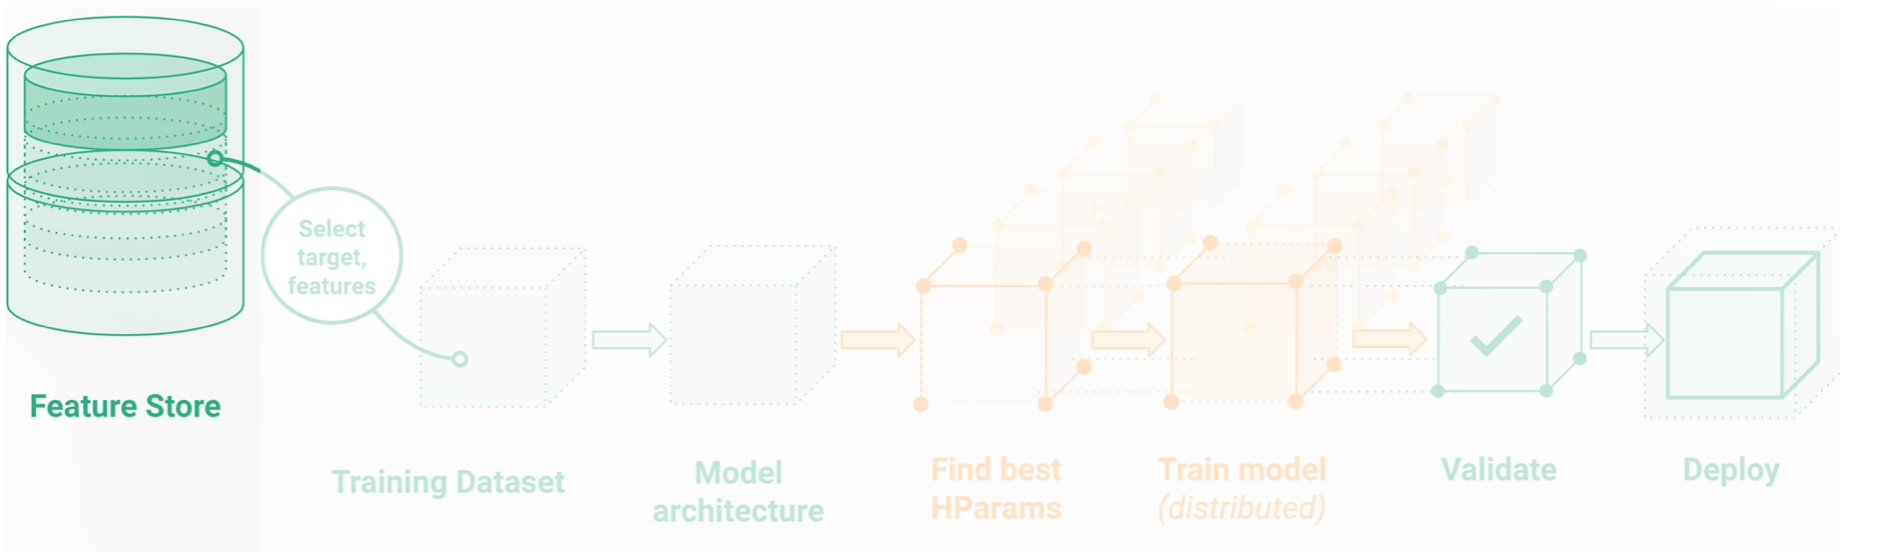

A feature store is not a pure storage service, it goes hand-in-hand with feature computation. Feature engineering is the process of transforming raw data into a format that is compatible and understandable for predictive models.


---

# 👷🏼‍♂️ Feature Engineering

This section consists of next steps:

1. Import the libraries we need for feature engineering.
2. Define the feature engineering functions.
3. Loading Datasets.

### 📝 Imports

In [1]:
# Import necessary libraries for feature engineering
# common libaries for hashing and date time conversions
import hashlib
from datetime import datetime

# pandas for feature engineering 
import pandas as pd
import numpy as np

# Hops hdfs utility library for reading and writing files from HopsFs
from hops import hdfs

In [2]:
project_name = hdfs.project_name()
project_path = hdfs.project_path()

project_name

'aml_demo'

### 🧰 Feature Engineering Functions

In [3]:
def timestamp_2_unix_epoch(x):
    dt_obj = datetime.strptime(str(x), '%Y-%m-%d %H:%M:%S')
    dt_obj = dt_obj.timestamp() * 1000
    return dt_obj

### ⬇️ Loading Datasets

#### ⛳️ Transactions dataset preparation

In [4]:
transactions_df = pd.read_csv(
    f"{project_path}/Jupyter/AMLend2end/demodata/transactions.csv",
    parse_dates = ['tran_timestamp']
)

/srv/hops/anaconda/envs/theenv/lib/python3.8/site-packages/fsspec/implementations/hdfs.py:83: FutureWarning: pyarrow.hdfs.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  self.client = HadoopFileSystem(


In [5]:
transactions_df.tran_timestamp = transactions_df.tran_timestamp.apply(lambda x: timestamp_2_unix_epoch(str(x)[:19])).astype(np.int64)

transactions_df.columns = ['tran_id', 'tx_type', 'base_amt', 'tran_timestamp', 'source', 'target']
transactions_df = transactions_df[["source","target","tran_timestamp","tran_id", "base_amt"]]

transactions_df.head()

,source,target,tran_timestamp,tran_id,base_amt
0,3aa9646b,1e46e726,1577836800000,496,858.77
1,49203bc3,a74d1101,1577836800000,1342,386.86
2,616d4505,99af2455,1577923200000,1580,616.43
3,39be1ea2,e7ec7bdb,1577923200000,2866,146.44
4,e2e0d938,afc399a9,1578009600000,3997,439.09


In [6]:
transactions_df.dtypes

source             object
target             object
tran_timestamp      int64
tran_id             int64
base_amt          float64
dtype: object

#### ⛳️ Alert Transactions dataset preparation

In [7]:
alert_transactions = pd.read_csv(f"{project_path}/Jupyter/AMLend2end/demodata/alert_transactions.csv")

alert_transactions.head()

,alert_id,alert_type,is_sar,tran_id
0,47,gather_scatter,True,11873
1,47,gather_scatter,True,11874
2,47,gather_scatter,True,11875
3,47,gather_scatter,True,13151
4,47,gather_scatter,True,23148


In [8]:
alert_transactions.is_sar = alert_transactions.is_sar.map({True: 1, False: 0})
alert_transactions.sort_values('tran_id',inplace = True)
alert_transactions.head()

,alert_id,alert_type,is_sar,tran_id
0,47,gather_scatter,1,11873
1,47,gather_scatter,1,11874
2,47,gather_scatter,1,11875
3,47,gather_scatter,1,13151
4,47,gather_scatter,1,23148


#### ⛳️ Party dataset preparation

In [9]:
party = pd.read_csv(f"{project_path}/Jupyter/AMLend2end/demodata/party.csv")

party.head()

,partyId,partyType
0,5628bd6c,Organization
1,a1fcba39,Organization
2,f56c9501,Individual
3,9969afdd,Organization
4,b356eeae,Individual


In [10]:
party.columns = ["id","type"]

party.head()

,id,type
0,5628bd6c,Organization
1,a1fcba39,Organization
2,f56c9501,Individual
3,9969afdd,Organization
4,b356eeae,Individual


---

# 👮🏼‍♀️ Data Validation

Before we define [feature groups](https://docs.hopsworks.ai/latest/generated/feature_group/) lets define [validation rules](https://docs.hopsworks.ai/latest/generated/feature_validation/) for features. We do expect some of the features to comply with certain *rules* or *expectations*. For example: a transacted amount must be a positive value. In the case of a transacted amount arriving as a negative value we can decide whether to stop it from `write` into a feature group and throw an error or allow it to be written but provide a warning. In the next section we will create feature store `expectations`, attach them to feature groups, and apply them to dataframes being appended to said feature group.

#### Data validation rules supported in Hopsworks
Hopsworks comes shipped with a set of data validation rules. These rules are **immutable**, uniquely identified by **name** and are available across all feature stores. These rules are used to create feature store expectations which can then be attached to individual feature groups.

### 🧑🏻‍🏫 HSFS library

The Hopsworks feature feature store library is called `hsfs` (**H**opswork**s** **F**eature **S**tore). 
The library is Apache V2 licensed and available [here](https://github.com/logicalclocks/feature-store-api). The library is currently available for Python and JVM languages such as Scala and Java.
In this notebook, we are going to cover Python part.

You can find the complete documentation of the library here: 

The first step is to establish a connection with your Hopsworks feature store instance and retrieve the object that represents the feature store you'll be working with. 

> By default `connection.get_feature_store()` returns the feature store of the project we are working with. However, it accepts also a project name as parameter to select a different feature store.

In [11]:
import hsfs
from hsfs.rule import Rule

# Create a connection
connection = hsfs.connection()

# Get the feature store handle for the project's feature store
fs = connection.get_feature_store()

Connected. Call `.close()` to terminate connection gracefully.


In [12]:
# Get all rule definitions available in Hopsworks
rules = connection.get_rules()

[rule.to_dict() for rule in rules]

[{'name': 'HAS_APPROX_COUNT_DISTINCT',
  'predicate': None,
  'acceptedType': 'Fractional',
  'featureType': None,
  'description': 'Assert on the approximate count distinct of a feature.'},
 {'name': 'HAS_CORRELATION',
  'predicate': 'FEATURE',
  'acceptedType': 'Fractional',
  'featureType': 'Numerical',
  'description': 'Assert on the pearson correlcation between two features.'},
 {'name': 'HAS_DATATYPE',
  'predicate': 'ACCEPTED_TYPE',
  'acceptedType': 'String',
  'featureType': None,
  'description': 'Assert on the fraction of rows that conform to the given data type.'},
 {'name': 'HAS_ENTROPY',
  'predicate': None,
  'acceptedType': 'Fractional',
  'featureType': None,
  'description': 'Assert on the entropy of a feature.'},
 {'name': 'HAS_MAX',
  'predicate': None,
  'acceptedType': 'Fractional',
  'featureType': 'Numerical',
  'description': 'Assert on the max of a feature.'},
 {'name': 'HAS_MUTUAL_INFORMATION',
  'predicate': 'FEATURE',
  'acceptedType': 'Fractional',
  'feat

In [13]:
# Get a rule definition by name
is_positive = connection.get_rule("IS_POSITIVE")

print(is_positive.to_dict())

{'name': 'IS_POSITIVE', 'predicate': None, 'acceptedType': 'Fractional', 'featureType': None, 'description': 'Assert on a feature containing non negative values.'}


### 🔬 Expectations
Expectations are created at the feature store level. Multiple expectations can be created per feature store.
An expectation consist of one or multiple rules and can refer to one or multiple features. An expectation can be utilized by attaching it to a feature group, as shown below.

In [14]:
expectation_amount = fs.create_expectation("amount",
                                           features=["base_amt"], 
                                           description="validate amount correctness",
                                           rules=[Rule(name="IS_POSITIVE", level="ERROR", max=10000000)])

expectation_amount.save()

---

# 🔮 Register Feature Groups

## 🧑🏻‍🏫 Feature Groups

A `Feature Groups` is a logical grouping of features, and experience has shown, that this grouping generally originates from the features being derived from the same data source. The `Feature Group` lets you save metadata along features, which defines how the Feature Store interprets them, combines them and reproduces training datasets created from them.

Generally, the features in a feature group are engineered together in an ingestion job. However, it is possible to have additional jobs to append features to an existing feature group. Furthermore, `feature groups` provide a way of defining a namespace for features, such that you can define features with the same name multiple times, but uniquely identified by the group they are contained in.

> It is important to note that `feature groups` are not groupings of features for immediate training of Machine Learning models. Instead, to ensure reusability of features, it is possible to combine features from any number of groups into training datasets.



#### ⛳️ Transactions feature group

In [15]:
transactions_fg = fs.create_feature_group(
    name = "transactions_fg",
    version = 1,
    primary_key = ["tran_id"],
    partition_key = ["tran_timestamp"],   
    description = "transactions features",
    event_time = ['tran_timestamp'],
    time_travel_format = "HUDI",  
    online_enabled = True,
    statistics_config = {"enabled": True, "histograms": True, "correlations": True, "exact_uniqueness": False}    
)   

transactions_fg.save(transactions_df)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/transactions_fg_1_offline_fg_backfill/executions


#### ⛳️ Alert Transactions feature group

In [16]:
alert_transactions_fg = fs.create_feature_group(
    name = "alert_transactions_fg",
    version = 1,
    primary_key = ["tran_id"],
    partition_key = ["alert_type"],         
    description = "alert transactions",
    time_travel_format = "HUDI",     
    online_enabled = True,                                                
    statistics_config = {"enabled": True, "histograms": True, "correlations": True, "exact_uniqueness": False}
)

alert_transactions_fg.save(alert_transactions)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/alert_transactions_fg_1_offline_fg_backfill/executions


#### ⛳️ Party feature group

In [17]:
party_fg = fs.create_feature_group(
    name = "party_fg",
    version = 1,
    primary_key = ["id"],
    description = "party fg",
    time_travel_format = "HUDI",
    online_enabled = True,
    statistics_config = {"enabled": True, "histograms": True, "correlations": True, "exact_uniqueness": False}
)

party_fg.save(party)

Launching offline feature group backfill job...
Backfill Job started successfully, you can follow the progress at https://hopsworks.glassfish.service.consul:8182/p/119/jobs/named/party_fg_1_offline_fg_backfill/executions


---

### Feature groups exploration from the user interface

##### Hopsworks provides user interface that enables exploration and discovery of available Feature Groups and related features. Bellow screenshot demonstrates how one can preview the list of available features in `transactions_fg` and get basic information such as identify feature types and which one are used as primary and partition keys.    

![Incremental Feature Engineering](./images/feature_list.png)

##### We can also preview the data itself. This is similar to `.head()` method   

![Incremental Feature Engineering](./images/data_preview.png)

##### One of the important steps of feature group exploration is the discovery distribution of ist features and whether they are correlated or not. Since we enabled statistics to be computed during the feature group creation we can easily preview descriptive statistics.  

![Incremental Feature Engineering](./images/statistics.png)

##### We can also disover additional properties. Here we can see if there are expection attached to this feature group or not. Please note that we attached expectation using python API but it is also possible too attach and manage feature group expectations from the UI itself.

![Incremental Feature Engineering](./images/expecation.png)

##### Hopsworks UI also provide access to feature group activity timeline metadata.  
![Incremental Feature Engineering](./images/activity.png)

---